In [1]:
import torch
import random
import numpy as np

# 设置 Python 内置的随机数生成器的种子
random.seed(42)
# 设置 NumPy 的随机数生成器的种子
np.random.seed(42)
# 设置 PyTorch 随机数生成器的种子
torch.manual_seed(42)
# 如果使用 GPU, 设置 CUDA 随机数生成器的种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # 如果使用多个 GPU
# 确保所有操作都是确定性的
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
import numpy as np
import os
from Bio import SeqIO
def load_embeddings(npy_folder_path, max_length, embedding_type='proteinbert'):
    features_dict = {}
    for filename in os.listdir(npy_folder_path):
        if filename.endswith('.npy'):
            protein_id = filename[:-4]
            feature = np.load(os.path.join(npy_folder_path, filename))
            squeezed_feature = np.squeeze(feature)
            if squeezed_feature.shape[0] > max_length:
                padded_feature = squeezed_feature[:max_length, :]
            else:
                padding = np.zeros((max_length - squeezed_feature.shape[0], squeezed_feature.shape[1]))
                padded_feature = np.vstack([squeezed_feature, padding])
            features_dict[protein_id] = padded_feature
    return features_dict

def create_one_hot_features(fasta_file, max_length, amino_acids='ACDEFGHIKLMNPQRSTVWY'):
    aa_to_onehot = {aa: np.eye(len(amino_acids))[i] for i, aa in enumerate(amino_acids)}
    one_hot_features_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_id = record.id
        encoded_seq = np.array([aa_to_onehot.get(aa, np.zeros(len(amino_acids))) for aa in str(record.seq)])
        if len(encoded_seq) > max_length:
            encoded_seq = encoded_seq[:max_length]  # 截断超长序列
        padding_length = max_length - len(encoded_seq)
        if padding_length > 0:  # 仅当需要填充时进行填充
            padded_seq = np.pad(encoded_seq, ((0, padding_length), (0, 0)), 'constant')
        else:
            padded_seq = encoded_seq
        one_hot_features_dict[sequence_id] = padded_seq
    return one_hot_features_dict

# 更新最大长度为100
max_length = 183
# 调用函数

def combine_features(one_hot_features, proteinbert_features, esm_features):
    combined_features_dict = {}
    for seq_id in one_hot_features:
        if seq_id in proteinbert_features and seq_id in esm_features:
            combined_feature = np.concatenate([
                proteinbert_features[seq_id], 
                esm_features[seq_id], 
                one_hot_features[seq_id]
            ], axis=1)
            combined_features_dict[seq_id] = combined_feature
    return combined_features_dict

fasta_file = 'amp_eval2.fasta'
proteinbert_path = 'bert_amp_eval2'
esm_path = 'esm_ebd_amp_eval2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
amp_eval_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'non_amp_eval2.fasta'
proteinbert_path = 'bert_non_amp_eval2'
esm_path = 'esm_ebd_non_amp_eval2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
decoy_amp_eval_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'amp_test2.fasta'
proteinbert_path = 'bert_amp_test2'
esm_path = 'esm_ebd_amp_test2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
amp_test_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'non_amp_test2.fasta'
proteinbert_path = 'bert_non_amp_test2'
esm_path = 'esm_ebd_non_amp_test2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
decoy_amp_test_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'amp_train2.fasta'
proteinbert_path = 'bert_amp_train2'
esm_path = 'esm_ebd_amp_train2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
amp_train_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

fasta_file = 'non_amp_train2.fasta'
proteinbert_path = 'bert_non_amp_train2'
esm_path = 'esm_ebd_non_amp_train2'
one_hot_features = create_one_hot_features(fasta_file, max_length)
proteinbert_features = load_embeddings(proteinbert_path, max_length, 'proteinbert')
esm_features = load_embeddings(esm_path, max_length, 'esm')
decoy_amp_train_combined_features = combine_features(one_hot_features, proteinbert_features, esm_features)

In [3]:
from Bio.PDB import PDBParser
import torch
from torch_geometric.data import Data
import numpy as np
import os
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_residue_positions(pdb_file, max_residues=183):
    parser = PDBParser()
    structure = parser.get_structure('PDB', pdb_file)
    model = structure[0]  # Typically, only the first model is used

    residue_positions = []
    for chain in model:
        for residue in chain:
            if residue.id[0] == ' ' and 'CA' in residue:  # Filter out non-standard residues and ensure CA exists
                residue_positions.append(residue['CA'].coord)
                if len(residue_positions) >= max_residues:  # If reached max_residues, stop adding more residues
                    break
        if len(residue_positions) >= max_residues:
            break
    return residue_positions

def build_edges_with_attr(residue_positions, cutoff):
    edges = []
    edge_attrs = []
    num_residues = len(residue_positions)  # Get the number of residues (nodes)
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            dist = np.linalg.norm(residue_positions[i] - residue_positions[j])
            if dist < cutoff:
                edges.append([i, j])
                edges.append([j, i])
                edge_attrs.append([dist])
                edge_attrs.append([dist])
    # Convert to tensors and add boundary check
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    # Boundary check
    if edge_index.max().item() >= num_residues:
        raise ValueError(f"Edge index out of bounds! Max index: {edge_index.max().item()}, Num residues: {num_residues}")
    
    return edge_index, edge_attr

def create_graph(feature_array, pdb_file, cutoff=10.0, is_amp=True, max_residues=183):
    residue_positions = get_residue_positions(pdb_file, max_residues)
    edge_index, edge_attr = build_edges_with_attr(residue_positions, cutoff)
    x = torch.tensor(feature_array, dtype=torch.float)
    y = torch.tensor([1 if is_amp else 0], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def create_graphs_for_sequences(features_dict, pdb_folder, is_amp=True, max_residues=183):
    graphs = {}
    for seq_id, features in features_dict.items():
        pdb_file = os.path.join(pdb_folder, f"{seq_id}.pdb")
        if os.path.exists(pdb_file):
            try:
                graph = create_graph(features, pdb_file, is_amp=is_amp, max_residues=max_residues)
                graphs[seq_id] = graph
            except Exception as e:
                logging.error(f"Error processing {seq_id} from {pdb_file}: {e}")
        else:
            logging.warning(f"No PDB file found for {seq_id}")
    return graphs


amp_graphs = create_graphs_for_sequences(amp_eval_combined_features, 'pdb_amp_eval2', is_amp=True)
decoy_graphs = create_graphs_for_sequences(decoy_amp_eval_combined_features, 'pdb_non_amp_eval2', is_amp=False)

#for test files
amp_test_graphs = create_graphs_for_sequences(amp_test_combined_features, 'pdb_amp_test2', is_amp=True)
decoy_test_graphs = create_graphs_for_sequences(decoy_amp_test_combined_features, 'pdb_non_amp_test2', is_amp=False)


amp_train_graphs = create_graphs_for_sequences(amp_train_combined_features, 'pdb_amp_train2', is_amp=True)
decoy_train_graphs = create_graphs_for_sequences(decoy_amp_train_combined_features, 'pdb_non_amp_train2', is_amp=False)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class PeptideDataset(Dataset):
    def __init__(self, root_dir, fasta_file, max_vertices=None):
        self.root_dir = root_dir
        self.peptides = self.parse_fasta(fasta_file)
        self.max_vertices = max_vertices if max_vertices is not None else self.determine_max_vertices()

    def parse_fasta(self, fasta_file):
        peptides = []
        with open(fasta_file, 'r') as file:
            for line in file:
                if line.startswith('>'):
                    peptide_id = line.strip().split()[0][1:]
                    peptides.append(peptide_id)
        return peptides

    def determine_max_vertices(self):
        max_vertices = 0
        for peptide_id in self.peptides:
            path = os.path.join(self.root_dir, peptide_id, 'p1_input_feat.npy')
            if os.path.exists(path):
                current_vertices = np.load(path).shape[0]
                max_vertices = max(max_vertices, current_vertices)
        return max_vertices
    

    def __len__(self):
        return len(self.peptides)

    def __getitem__(self, idx):
        peptide_id = self.peptides[idx]
        try:
            features = {
                'input_feat': np.load(os.path.join(self.root_dir, peptide_id, 'p1_input_feat.npy')),
                'rho_coords': np.load(os.path.join(self.root_dir, peptide_id, 'p1_rho_wrt_center.npy')),
                'theta_coords': np.load(os.path.join(self.root_dir, peptide_id, 'p1_theta_wrt_center.npy')),
                'mask': np.load(os.path.join(self.root_dir, peptide_id, 'p1_mask.npy'))
            }

            max_vertices = 5109  # 设置最大顶点数为5109

            # 调整所有特征到max_vertices
            for key in features:
                current_length = features[key].shape[0]
                if current_length < max_vertices:
                    padding_shape = (max_vertices - current_length,) + features[key].shape[1:]
                    padding = np.zeros(padding_shape, dtype=features[key].dtype)
                    features[key] = np.concatenate((features[key], padding), axis=0)
                elif current_length > max_vertices:
                    features[key] = features[key][:max_vertices]
                
                features[key] = np.nan_to_num(features[key])

            label = 0 # 所有样本的标签都是
            features_tensor = {key: torch.tensor(val, dtype=torch.float32) for key, val in features.items()}
            return features_tensor, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading data for {peptide_id}: {e}")
            return None   # 遇到错误时返回None

In [6]:
root_dir = 'finger_amp_eval2'
fasta_file = 'amp_eval2.fasta'
model2_eval_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

root_dir = 'finger_amp_train2'
fasta_file = 'amp_train2.fasta'
model2_trian_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

root_dir = 'finger_amp_test2'
fasta_file = 'amp_test2.fasta'
model2_test_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

In [8]:
root_dir = 'finger_non_amp_eval2'
fasta_file = 'non_amp_eval2.fasta'
model2_decoy_eval_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

root_dir = 'finger_non_amp_test2'
fasta_file = 'non_amp_test2.fasta'
model2_decoy_test_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

root_dir = 'finger_non_amp_train2'
fasta_file = 'non_amp_train2.fasta'
model2_decoy_trian_amp_dataset = PeptideDataset(root_dir=root_dir, fasta_file=fasta_file)

In [9]:
GCN_train = list(amp_train_graphs.values()) + list(decoy_train_graphs.values())
GCN_eval = list(amp_graphs.values()) + list(decoy_graphs.values())
GCN_test = list(amp_test_graphs.values())+list(decoy_test_graphs.values())
fingerprint_trian = model2_trian_amp_dataset + model2_decoy_trian_amp_dataset
fingerprint_eval = model2_eval_amp_dataset + model2_decoy_eval_amp_dataset
fingerprint_test = model2_test_amp_dataset + model2_decoy_test_amp_dataset

In [10]:
from torch_geometric.data import Batch
class CombinedDataset(Dataset):
    def __init__(self, graph_dataset, feature_dataset):
        assert len(graph_dataset) == len(feature_dataset), "Datasets must be of the same size"
        self.graph_dataset = graph_dataset
        self.feature_dataset = feature_dataset

    def __len__(self):
        return len(self.graph_dataset)

    def __getitem__(self, idx):
        graph_data = self.graph_dataset[idx]
        feature_data, label = self.feature_dataset[idx]
        return graph_data, feature_data, label
    
train_combined_dataset = CombinedDataset(GCN_train, fingerprint_trian)
test_combined_dataset = CombinedDataset(GCN_test, fingerprint_test)
eval_combined_dataset = CombinedDataset(GCN_eval, fingerprint_eval)



def custom_collate_fn(batch):
    data_gcn_list = [item[0] for item in batch]  # 提取每个元组的第一部分
    data_masif_list = [item[1] for item in batch]  # 提取每个元组的第二部分

    # 对GCN数据进行批处理
    data_gcn_batch = Batch.from_data_list(data_gcn_list)

    # 对MaSIF数据进行批处理，假设MaSIF数据是一个字典
    masif_keys = data_masif_list[0].keys()
    data_masif_batch = {key: torch.stack([d[key] for d in data_masif_list]) for key in masif_keys}
    
    return data_gcn_batch, data_masif_batch


#final_train_dataset = train_combined_dataset + eval_combined_dataset
train_combined_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_combined_loader = DataLoader(test_combined_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
eval_combined_loader = DataLoader(eval_combined_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Dropout, LayerNorm
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, global_mean_pool
from torch_geometric.nn import global_mean_pool

# 定义ImprovedGCN模型
class ImprovedGCNWithTransformer(torch.nn.Module):
    def __init__(self, num_features, num_classes, heads=4, dropout_rate=0.5, transformer_out_channels=64):
        super(ImprovedGCNWithTransformer, self).__init__()
        self.conv1 = GCNConv(num_features, 1024)
        self.conv2 = GCNConv(1024, 512)
        self.conv3 = GCNConv(512, 256)
        self.linear_transform = Linear(256, transformer_out_channels)  # 调整维度以匹配Transformer的输入

        # Transformer layer
        self.transformer = TransformerConv(transformer_out_channels, transformer_out_channels, heads=heads, dropout=dropout_rate, concat=True)
        self.layer_norm = LayerNorm(transformer_out_channels * heads)  # 层归一化

        self.attn1 = GATConv(transformer_out_channels * heads, 16 // heads, heads=heads, concat=True)
        self.fc = Linear(16, num_classes)
        self.dropout = Dropout(dropout_rate)

    def forward(self, data, return_features = False ):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)

        x = self.linear_transform(x)  # 调整维度
        x = self.transformer(x, edge_index)  # 应用Transformer层
        x = self.layer_norm(x)  # 应用层归一化
        x = F.elu(x)

        x = self.attn1(x, edge_index)  # 应用注意力层
        x = global_mean_pool(x, data.batch)  # 全局平均池化
        if return_features:
            return x
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# 定义MaSIF_site_PyTorch模型
class MaSIF_site_PyTorch(nn.Module):
    def __init__(self, n_thetas, n_rhos, n_feat, n_rotations, dropout_rate=0.5):
        super(MaSIF_site_PyTorch, self).__init__()
        self.n_thetas = n_thetas
        self.n_rhos = n_rhos
        self.n_feat = n_feat
        self.n_rotations = n_rotations

        # Parameters
        self.mu_rho = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.sigma_rho = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.mu_theta = nn.Parameter(torch.Tensor(self.n_rotations, 1))
        self.sigma_theta = nn.Parameter(torch.Tensor(self.n_rotations, 1))

        # Initialize parameters
        nn.init.uniform_(self.mu_rho, 0, 1)
        nn.init.constant_(self.sigma_rho, 0.5)
        nn.init.uniform_(self.mu_theta, 0, 2 * np.pi)
        nn.init.constant_(self.sigma_theta, 0.5)

        # Layers
        self.avgpool1d = nn.AvgPool1d(kernel_size=6, stride=5)  # Adjust these values based on desired output size
        self.fc1 = nn.Linear(40840, 2)

    def forward(self, input_feat, rho_coords, theta_coords, mask, return_features = False):
        batch_size, n_vertices, num_points, n_feat = input_feat.size()
        input_feat = input_feat.mean(dim=2)

        output_feats = []
        for k in range(self.n_rotations):
            rotated_theta_coords = theta_coords + k * 2 * np.pi / self.n_rotations
            rotated_theta_coords %= 2 * np.pi

            rho_gauss = torch.exp(-torch.square(rho_coords - self.mu_rho[k]) / (2 * torch.square(self.sigma_rho[k]) + 1e-5))
            theta_gauss = torch.exp(-torch.square(rotated_theta_coords - self.mu_theta[k]) / (2 * torch.square(self.sigma_theta[k]) + 1e-5))

            gauss_activations = rho_gauss * theta_gauss * mask
            gauss_activations /= torch.sum(gauss_activations, dim=1, keepdim=True) + 1e-5

            gauss_activations = gauss_activations.unsqueeze(3)
            gauss_activations = gauss_activations.expand(-1, -1, -1, n_feat)

            gauss_desc = torch.sum(gauss_activations * input_feat.unsqueeze(2), dim=2)
            output_feats.append(gauss_desc)
        
        output_feats = torch.cat(output_feats, dim=2)
        #print(output_feats.shape)
        output_feats = output_feats.permute(0, 2, 1)  # [batch_size, 40, 5109]
        #print(output_feats.shape)
        # Apply AvgPool1d to reduce the middle dimension from 5109 to 1000
        output_feats = self.avgpool1d(output_feats)  # [batch_size, 40, 1000]
        #print(output_feats.shape)
        output_feats = output_feats.permute(0, 2, 1)  # [batch_size, 1000, 40]
        #print(output_feats.shape)
        output_feats = output_feats.reshape(batch_size, -1)  # Flatten to feed into the linear layer
        
        if return_features:
            return output_feats

In [12]:
class FusionModel(nn.Module):
    def __init__(self, model_gcn, model_masif, output_features, num_classes):
        super(FusionModel, self).__init__()
        self.model_gcn = model_gcn
        self.model_masif = model_masif
        self.fusion_layer = nn.Linear(output_features, 2)

    def forward(self, data_gcn, data_masif):
        # 提取各自模型的特征
        gcn_features = self.model_gcn(data_gcn, return_features=True)
        input_feat = data_masif['input_feat']
        rho_coords = data_masif['rho_coords']
        theta_coords = data_masif['theta_coords']
        mask = data_masif['mask']
        masif_features = self.model_masif(input_feat, rho_coords, theta_coords, mask, return_features=True)
        #print("GCN Features Shape:", gcn_features.shape)
        #print("MaSIF Features Shape:", masif_features.shape)

        # 特征融合
        combined_features = torch.cat((gcn_features, masif_features), dim=1)
        combined_features = F.relu(combined_features)
        
        # 分类层
        output = self.fusion_layer(combined_features)
        return F.log_softmax(output, dim=1)

# 设置设备
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# 实例化单独的模型
model_gcn = ImprovedGCNWithTransformer(num_features=3604, num_classes=2).to(device)
model_masif = MaSIF_site_PyTorch(n_thetas=16, n_rhos=5, n_feat=5, n_rotations=8).to(device)

# 假设从GCN和MaSIF模型中提取的特征数量，需要根据具体情况来设置
gcn_output_features = 32  # 假设GCN模型最后一个GAT层输出32维特征
masif_output_features = 5 * 8  # MaSIF模型输出8次旋转的5维特征

# 实例化融合模型
fusion_model = FusionModel(model_gcn, model_masif, 40856, num_classes=2).to(device)

In [13]:
from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(fusion_model.parameters(), lr=0.00001, weight_decay=6e-1)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=10)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
best_accuracy = 0.0  # 初始化最高准确性
best_model1_path = '12_9_ben1transfinger_model1.pth'  # 定义最好模型的保存路径
# 定义损失函数
criterion = nn.CrossEntropyLoss()
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # 关闭梯度计算
        for data_gcn, data_masif in data_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)
            
            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # 计算总体指标
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * total_correct / total_samples
        auc_score = roc_auc_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = matthews_corrcoef(all_labels, all_preds)

    return avg_loss, accuracy, auc_score, sensitivity, specificity, mcc
epochs = 10
# 训练循环
for epoch in range(epochs):
    fusion_model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for data_gcn, data_masif in train_combined_loader:
        # 处理数据
        data_gcn.to(device)
        input_feat = data_masif['input_feat'].to(device)
        rho_coords = data_masif['rho_coords'].to(device)
        theta_coords = data_masif['theta_coords'].to(device)
        mask = data_masif['mask'].to(device)
        labels = data_gcn.y.to(device)

        # 清空梯度
        optimizer.zero_grad()

        # 正向传播
        outputs = fusion_model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})

        # 计算损失
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算准确性
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # 输出训练性能
    avg_loss = total_loss / len(train_combined_loader)
    accuracy = 100 * total_correct / total_samples
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')

    # 在测试集上评估模型
    test_loss, test_accuracy, test_auc, test_sens, test_spec, test_mcc = evaluate_model(fusion_model, test_combined_loader, criterion, device)
    print(f'Epoch {epoch+1}/{epochs}: Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, AUC: {test_auc:.4f}, SENS: {test_sens:.4f}, SPEC: {test_spec:.4f}, MCC: {test_mcc:.4f}')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy  # 更新最高准确性
        torch.save(fusion_model.state_dict(), best_model1_path)  # 保存模型
        print(f'Saved new best model with accuracy: {best_accuracy:.2f}%')
    scheduler_cosine.step()
    scheduler_plateau.step(test_loss)

Epoch 1/10, Train Loss: 0.6906, Train Accuracy: 62.38%
Epoch 1/10: Test Loss: 0.6854, Accuracy: 70.32%, AUC: 0.6967, SENS: 0.7394, SPEC: 0.6540, MCC: 0.3929
Saved new best model with accuracy: 70.32%
Epoch 2/10, Train Loss: 0.6800, Train Accuracy: 71.77%
Epoch 2/10: Test Loss: 0.6708, Accuracy: 75.61%, AUC: 0.7543, SENS: 0.7662, SPEC: 0.7424, MCC: 0.5052
Saved new best model with accuracy: 75.61%
Epoch 3/10, Train Loss: 0.6642, Train Accuracy: 76.92%
Epoch 3/10: Test Loss: 0.6542, Accuracy: 78.77%, AUC: 0.7941, SENS: 0.7528, SPEC: 0.8354, MCC: 0.5812
Saved new best model with accuracy: 78.77%
Epoch 4/10, Train Loss: 0.6463, Train Accuracy: 79.80%
Epoch 4/10: Test Loss: 0.6345, Accuracy: 82.06%, AUC: 0.8232, SENS: 0.8065, SPEC: 0.8399, MCC: 0.6401
Saved new best model with accuracy: 82.06%
Epoch 5/10, Train Loss: 0.6285, Train Accuracy: 81.99%
Epoch 5/10: Test Loss: 0.6157, Accuracy: 82.58%, AUC: 0.8192, SENS: 0.8624, SPEC: 0.7759, MCC: 0.6418
Saved new best model with accuracy: 82.58%


Model loaded from 12_9_ben1transfinger_model1.pth
Test Loss: 0.6025, Accuracy: 83.16%, AUC: 0.8943, SENS: 0.8434, SPEC: 0.8155, MCC: 0.6566


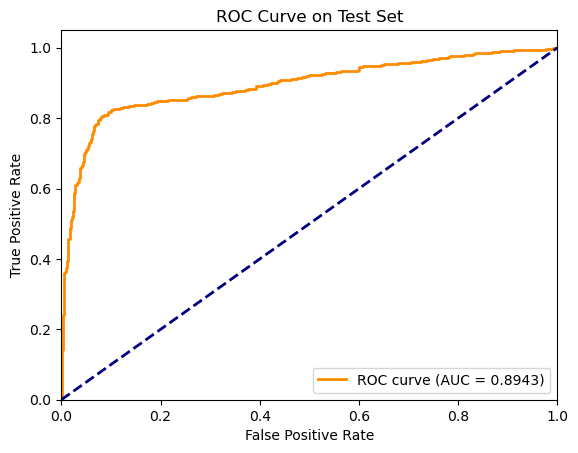

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, matthews_corrcoef, accuracy_score

# 定义一个加载模型的函数
def load_model(model, path='12_9_ben1transfinger_model1.pth'):
    model.load_state_dict(torch.load(path))
    print(f'Model loaded from {path}')
    return model

# 定义一个绘制 ROC 曲线的函数
def plot_roc_curve(labels, scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# 使用最佳模型在测试集上进行测试并打印所有指标
def test_model_and_print_metrics(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_scores = []  # 用于保存正类的概率
    all_preds = []   # 保存预测值

    with torch.no_grad():
        for data_gcn, data_masif in test_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)

            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # 获取预测概率和预测值
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 获取正类的预测概率
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 获取预测值
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_scores.extend(scores)  # 保存正类的预测概率
            all_preds.extend(preds)    # 保存预测值
            total_correct += (preds == labels).sum()
            total_samples += labels.shape[0]

    # 计算测试集损失
    test_loss /= len(test_loader)

    # 计算 Accuracy
    accuracy = total_correct / total_samples * 100

    # 计算 AUC
    auc_score = roc_auc_score(all_labels, all_scores)

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # 计算 Sensitivity 和 Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # 计算 MCC
    mcc = matthews_corrcoef(all_labels, all_preds)

    # 获取当前学习率
    #current_lr = optimizer.param_groups[0]['lr']

    # 打印所有指标
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, AUC: {auc_score:.4f}, '
          f'SENS: {sensitivity:.4f}, SPEC: {specificity:.4f}, MCC: {mcc:.4f}')
    #print(f'Current learning rate: {current_lr:.8f}')
    
    # 绘制 ROC 曲线
    plot_roc_curve(all_labels, all_scores, title="ROC Curve on Test Set")
best_model2_path = '12_9_ben1transfinger_model1.pth' 
# 加载模型并进行测试
fusion_model = FusionModel(model_gcn, model_masif, 40856, num_classes=2).to(device)
fusion_model.to(device)
# 加载之前保存的最佳模型
fusion_model = load_model(fusion_model, best_model2_path)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()

# 使用最佳模型在测试集上进行推理并绘制 ROC 曲线
test_model_and_print_metrics(fusion_model, test_combined_loader, criterion)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

# 融合模型类
class FusionModel(nn.Module):
    def __init__(self, model_gcn, model_masif, output_features, num_classes):
        super(FusionModel, self).__init__()
        self.model_gcn = model_gcn
        self.model_masif = model_masif
        self.expand_gcn = nn.Linear(16, 256)  # 例如256
        # MaSIF的输出降维到同样的维度
        self.reduce_masif = nn.Linear(40840, 256)  # 例如256
        # 融合后的特征进一步连接到分类器
        self.fusion_layer = nn.Linear(2 * 256, num_classes)
        
    def forward(self, data_gcn, data_masif):
        # 提取各自模型的特征
        gcn_features = self.model_gcn(data_gcn, return_features=True)
        input_feat = data_masif['input_feat']
        rho_coords = data_masif['rho_coords']
        theta_coords = data_masif['theta_coords']
        mask = data_masif['mask']
        masif_features = self.model_masif(input_feat, rho_coords, theta_coords, mask, return_features=True)
        #print("GCN Features Shape:", gcn_features.shape)
        #print("MaSIF Features Shape:", masif_features.shape)
        
        gcn_features = F.relu(self.expand_gcn(gcn_features))
        masif_features = F.relu(self.reduce_masif(masif_features))
        # 特征融合
        combined_features = torch.cat((gcn_features, masif_features), dim=1)
        #combined_features = F.relu(combined_features)
        
        # 分类层
        output = self.fusion_layer(combined_features)
        return F.log_softmax(output, dim=1)

# 设置设备
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# 实例化单独的模型
model_gcn = ImprovedGCNWithTransformer(num_features=3604, num_classes=2).to(device)
model_masif = MaSIF_site_PyTorch(n_thetas=16, n_rhos=5, n_feat=5, n_rotations=8).to(device)

# 假设从GCN和MaSIF模型中提取的特征数量，需要根据具体情况来设置
gcn_output_features = 32  # 假设GCN模型最后一个GAT层输出32维特征
masif_output_features = 5 * 8  # MaSIF模型输出8次旋转的5维特征
total_output_features = 40840

# 实例化融合模型
fusion_model = FusionModel(model_gcn, model_masif, 40840, num_classes=2).to(device)

In [16]:
from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(fusion_model.parameters(), lr=0.00002, weight_decay=6e-1)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=10)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
best_accuracy = 0.0  # 初始化最高准确性
best_model1_path = '12_9_ben1transfinger_model2.pth'  # 定义最好模型的保存路径
# 定义损失函数
criterion = nn.CrossEntropyLoss()
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # 关闭梯度计算
        for data_gcn, data_masif in data_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)
            
            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # 计算总体指标
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * total_correct / total_samples
        auc_score = roc_auc_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = matthews_corrcoef(all_labels, all_preds)

    return avg_loss, accuracy, auc_score, sensitivity, specificity, mcc
epochs = 20
# 训练循环
best_accuracy = 0.0  
best_lr = 0.0
best_weight_decay = 5e-1  # 此值应与你的优化器初始设置相匹配

# 训练循环
for epoch in range(epochs):
    fusion_model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for data_gcn, data_masif in train_combined_loader:
        # 处理数据
        data_gcn.to(device)
        input_feat = data_masif['input_feat'].to(device)
        rho_coords = data_masif['rho_coords'].to(device)
        theta_coords = data_masif['theta_coords'].to(device)
        mask = data_masif['mask'].to(device)
        labels = data_gcn.y.to(device)

        # 清空梯度
        optimizer.zero_grad()

        # 正向传播
        outputs = fusion_model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})

        # 计算损失
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算准确性
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # 输出训练性能
    avg_loss = total_loss / len(train_combined_loader)
    accuracy = 100 * total_correct / total_samples
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')

    # 在测试集上评估模型
    test_loss, test_accuracy, test_auc, test_sens, test_spec, test_mcc = evaluate_model(fusion_model, test_combined_loader, criterion, device)
    print(f'Epoch {epoch+1}/{epochs}: Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, AUC: {test_auc:.4f}, SENS: {test_sens:.4f}, SPEC: {test_spec:.4f}, MCC: {test_mcc:.4f}')
    
    # 更新调度器
    scheduler_cosine.step()
    scheduler_plateau.step(test_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy  # 更新最高准确性
        best_lr = current_lr  # 保存最佳学习率
        torch.save(fusion_model.state_dict(), best_model1_path)  # 保存模型
        print(f'Saved new best model with accuracy: {best_accuracy:.2f}% and learning rate: {best_lr:.6f}')

# 最后输出最佳模型的学习率
print(f'Best model learning rate: {best_lr:.6f}')

Epoch 1/20, Train Loss: 0.6221, Train Accuracy: 66.93%
Epoch 1/20: Test Loss: 0.5170, Accuracy: 78.71%, AUC: 0.7945, SENS: 0.7461, SPEC: 0.8430, MCC: 0.5821
Current learning rate: 0.000020
Saved new best model with accuracy: 78.71% and learning rate: 0.000020
Epoch 2/20, Train Loss: 0.4683, Train Accuracy: 81.68%
Epoch 2/20: Test Loss: 0.4057, Accuracy: 84.19%, AUC: 0.8409, SENS: 0.8479, SPEC: 0.8338, MCC: 0.6784
Current learning rate: 0.000018
Saved new best model with accuracy: 84.19% and learning rate: 0.000018
Epoch 3/20, Train Loss: 0.3950, Train Accuracy: 85.98%
Epoch 3/20: Test Loss: 0.3729, Accuracy: 86.06%, AUC: 0.8630, SENS: 0.8479, SPEC: 0.8780, MCC: 0.7197
Current learning rate: 0.000016
Saved new best model with accuracy: 86.06% and learning rate: 0.000016
Epoch 4/20, Train Loss: 0.3596, Train Accuracy: 86.87%
Epoch 4/20: Test Loss: 0.3579, Accuracy: 86.65%, AUC: 0.8723, SENS: 0.8345, SPEC: 0.9101, MCC: 0.7362
Current learning rate: 0.000013
Saved new best model with accur

KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, matthews_corrcoef, accuracy_score

# 定义一个加载模型的函数
def load_model(model, path='12_9_ben1transfinger_model2.pth'):
    model.load_state_dict(torch.load(path))
    print(f'Model loaded from {path}')
    return model

# 定义一个绘制 ROC 曲线的函数
def plot_roc_curve(labels, scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# 使用最佳模型在测试集上进行测试并打印所有指标
def test_model_and_print_metrics(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_scores = []  # 用于保存正类的概率
    all_preds = []   # 保存预测值

    with torch.no_grad():
        for data_gcn, data_masif in test_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)

            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # 获取预测概率和预测值
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 获取正类的预测概率
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 获取预测值
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_scores.extend(scores)  # 保存正类的预测概率
            all_preds.extend(preds)    # 保存预测值
            total_correct += (preds == labels).sum()
            total_samples += labels.shape[0]

    # 计算测试集损失
    test_loss /= len(test_loader)

    # 计算 Accuracy
    accuracy = total_correct / total_samples * 100

    # 计算 AUC
    auc_score = roc_auc_score(all_labels, all_scores)

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # 计算 Sensitivity 和 Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # 计算 MCC
    mcc = matthews_corrcoef(all_labels, all_preds)

    # 获取当前学习率
    #current_lr = optimizer.param_groups[0]['lr']

    # 打印所有指标
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, AUC: {auc_score:.4f}, '
          f'SENS: {sensitivity:.4f}, SPEC: {specificity:.4f}, MCC: {mcc:.4f}')
    #print(f'Current learning rate: {current_lr:.8f}')
    
    # 绘制 ROC 曲线
    plot_roc_curve(all_labels, all_scores, title="ROC Curve on Test Set")
best_model2_path = '12_9_ben1transfinger_model2.pth' 
# 加载模型并进行测试
fusion_model = FusionModel(model_gcn, model_masif, 40840, num_classes=2).to(device)
fusion_model.to(device)
# 加载之前保存的最佳模型
fusion_model = load_model(fusion_model, best_model2_path)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()

# 使用最佳模型在测试集上进行推理并绘制 ROC 曲线
test_model_and_print_metrics(fusion_model, test_combined_loader, criterion)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention

class FusionModel(nn.Module):
    def __init__(self, model_gcn, model_masif, output_features, num_classes):
        super(FusionModel, self).__init__()
        self.model_gcn = model_gcn
        self.model_masif = model_masif
        self.expand_gcn = nn.Linear(16, 256)  # 升维GCN特征至256
        self.reduce_masif = nn.Linear(40840, 256)  # 降维MaSIF特征至256
        
        # 添加 MultiheadAttention 层
        self.attention = MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        
        # 用于预处理注意力层输出的线性层
        self.attn_linearity = nn.Linear(512, 256)
        
        # 融合后的特征进一步连接到分类器
        self.fusion_layer = nn.Linear(256, num_classes)

    def forward(self, data_gcn, data_masif):
        gcn_features = self.model_gcn(data_gcn, return_features=True)
        masif_features = self.model_masif(data_masif['input_feat'], data_masif['rho_coords'], data_masif['theta_coords'], data_masif['mask'], return_features=True)
        
        gcn_features = F.relu(self.expand_gcn(gcn_features))
        masif_features = F.relu(self.reduce_masif(masif_features))

        # 将 GCN 和 MaSIF 特征进行拼接后送入注意力层
        combined_features = torch.cat((gcn_features, masif_features), dim=1).unsqueeze(0)  # 注意调整形状以匹配MultiheadAttention的输入要求
        
        # 应用 Multihead Attention
        attn_output, attn_weights = self.attention(combined_features, combined_features, combined_features)
        attn_output = attn_output.squeeze(0)  # 移除多余的批量维度
        
        # 可选：使用额外的线性层处理注意力层输出
        attn_output = self.attn_linearity(attn_output)
        
        # 分类层
        output = self.fusion_layer(attn_output)
        return F.log_softmax(output, dim=1)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# 实例化单独的模型
model_gcn = ImprovedGCNWithTransformer(num_features=3604, num_classes=2).to(device)
model_masif = MaSIF_site_PyTorch(n_thetas=16, n_rhos=5, n_feat=5, n_rotations=8).to(device)

# 假设从GCN和MaSIF模型中提取的特征数量，需要根据具体情况来设置
gcn_output_features = 32  # 假设GCN模型最后一个GAT层输出32维特征
masif_output_features = 5 * 8  # MaSIF模型输出8次旋转的5维特征
total_output_features = 40840

# 实例化融合模型
fusion_model = FusionModel(model_gcn, model_masif, 40840, num_classes=2).to(device)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(fusion_model.parameters(), lr=0.00002, weight_decay=6e-1)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=10)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
best_accuracy = 0.0  # 初始化最高准确性
best_model_path = '12_9_ben1transfinger_model3.pth'  # 定义最好模型的保存路径
# 定义损失函数
criterion = nn.CrossEntropyLoss()
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # 关闭梯度计算
        for data_gcn, data_masif in data_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)
            
            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # 计算总体指标
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * total_correct / total_samples
        auc_score = roc_auc_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = matthews_corrcoef(all_labels, all_preds)

    return avg_loss, accuracy, auc_score, sensitivity, specificity, mcc
epochs = 30
# 训练循环
for epoch in range(epochs):
    fusion_model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for data_gcn, data_masif in train_combined_loader:
        # 处理数据
        data_gcn.to(device)
        input_feat = data_masif['input_feat'].to(device)
        rho_coords = data_masif['rho_coords'].to(device)
        theta_coords = data_masif['theta_coords'].to(device)
        mask = data_masif['mask'].to(device)
        labels = data_gcn.y.to(device)

        # 清空梯度
        optimizer.zero_grad()

        # 正向传播
        outputs = fusion_model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})

        # 计算损失
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算准确性
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # 输出训练性能
    avg_loss = total_loss / len(train_combined_loader)
    accuracy = 100 * total_correct / total_samples
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')

    # 在测试集上评估模型
    test_loss, test_accuracy, test_auc, test_sens, test_spec, test_mcc = evaluate_model(fusion_model, test_combined_loader, criterion, device)
    print(f'Epoch {epoch+1}/{epochs}: Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, AUC: {test_auc:.4f}, SENS: {test_sens:.4f}, SPEC: {test_spec:.4f}, MCC: {test_mcc:.4f}')
    # 检查是否为最好的模型
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy  # 更新最高准确性
        torch.save(fusion_model.state_dict(), best_model_path)  # 保存模型
        print(f'Saved new best model with accuracy: {best_accuracy:.2f}%')
    scheduler_cosine.step()
    scheduler_plateau.step(test_loss)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, matthews_corrcoef, accuracy_score

# 定义一个加载模型的函数
def load_model(model, path='12_9_ben1transfinger_model3.pth'):
    model.load_state_dict(torch.load(path))
    print(f'Model loaded from {path}')
    return model

# 定义一个绘制 ROC 曲线的函数
def plot_roc_curve(labels, scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# 使用最佳模型在测试集上进行测试并打印所有指标
def test_model_and_print_metrics(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_scores = []  # 用于保存正类的概率
    all_preds = []   # 保存预测值

    with torch.no_grad():
        for data_gcn, data_masif in test_loader:
            # 数据处理
            data_gcn.to(device)
            input_feat = data_masif['input_feat'].to(device)
            rho_coords = data_masif['rho_coords'].to(device)
            theta_coords = data_masif['theta_coords'].to(device)
            mask = data_masif['mask'].to(device)
            labels = data_gcn.y.to(device)

            # 正向传播
            outputs = model(data_gcn, {'input_feat': input_feat, 'rho_coords': rho_coords, 'theta_coords': theta_coords, 'mask': mask})
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # 获取预测概率和预测值
            scores = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 获取正类的预测概率
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 获取预测值
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_scores.extend(scores)  # 保存正类的预测概率
            all_preds.extend(preds)    # 保存预测值
            total_correct += (preds == labels).sum()
            total_samples += labels.shape[0]

    # 计算测试集损失
    test_loss /= len(test_loader)

    # 计算 Accuracy
    accuracy = total_correct / total_samples * 100

    # 计算 AUC
    auc_score = roc_auc_score(all_labels, all_scores)

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # 计算 Sensitivity 和 Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # 计算 MCC
    mcc = matthews_corrcoef(all_labels, all_preds)

    # 获取当前学习率
    #current_lr = optimizer.param_groups[0]['lr']

    # 打印所有指标
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, AUC: {auc_score:.4f}, '
          f'SENS: {sensitivity:.4f}, SPEC: {specificity:.4f}, MCC: {mcc:.4f}')
    #print(f'Current learning rate: {current_lr:.8f}')
    
    # 绘制 ROC 曲线
    plot_roc_curve(all_labels, all_scores, title="ROC Curve on Test Set")
best_model2_path = '12_9_ben1transfinger_model1.pth' 
# 加载模型并进行测试
fusion_model = FusionModel(model_gcn, model_masif, 40840, num_classes=2).to(device)
fusion_model.to(device)
# 加载之前保存的最佳模型
fusion_model = load_model(fusion_model, best_model2_path)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()

# 使用最佳模型在测试集上进行推理并绘制 ROC 曲线
test_model_and_print_metrics(fusion_model, test_combined_loader, criterion)